In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Some configs

In [ ]:
import os

#specify the shape of the inputs to the network
IMG_SHAPE=(160,160,3)

#specify the batch size and number of epochs
BATCH_SIZE=60
EPOCHS=100

#define the path to the base output directory
BASE_OUTPUT="/tmp/output"

#use the base output to derive the path to the serialized
#model along with training history plot

MODEL_PATH=os.path.sep.join([BASE_OUTPUT,"siamese_model"])
PLOT_PATH=os.path.sep.join([BASE_OUTPUT,"plot.png"])

In [ ]:
#import the necessary packages

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D

In [ ]:

from tensorflow.keras.models import load_model

In [ ]:
faceNet=load_model('/content/drive/MyDrive/Datasets/facenet_keras.h5')

In [ ]:
faceNet.load_weights('/content/drive/MyDrive/Datasets/facenet_keras_weights.h5')

In [ ]:
for layer in faceNet.layers:
  layer.trainable=False

#### Build a siamese model for constructing sister networks

In [ ]:
from tensorflow.keras import layers
def build_siamese_model(inputShape,embeddingDim=128):
  #specify the inputs for the feature extractor network
  inputs=Input(inputShape)
  

  outputs=faceNet(inputs)

  #build the model
  model=Model(inputs,outputs)

  #return the model to the calling function
  return model

In [ ]:
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors
	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)
	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [ ]:
def plot_training(H, plotPath):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.savefig(plotPath)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input 
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
import numpy as np

In [ ]:
imgA=Input(shape=IMG_SHAPE)
imgB=Input(shape=IMG_SHAPE)

featureExtractor=build_siamese_model(IMG_SHAPE)
featsA=featureExtractor(imgA)
featsB=featureExtractor(imgB)

In [ ]:
#finally construct the siamese network

distance=Lambda(euclidean_distance)([featsA,featsB])
outputs=Dense(1,activation="sigmoid")(distance)
model=Model(inputs=[imgA,imgB],outputs=outputs)

#### Preprocess the data into image pairs

In [ ]:
# Extract zipped data
from zipfile import ZipFile
file_name=path="/content/drive/MyDrive/Datasets/TrainSet.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall('/tmp')
  print('Done')

Done


In [ ]:
from zipfile import ZipFile
file_name=path="/content/drive/MyDrive/Datasets/TestSet.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall('/tmp')
  print('Done')

Done


In [ ]:
import os
import cv2
from os import listdir
import numpy as np
trainingPath="/tmp/EXTRACTED_FACES-train/"
Trainimages=np.zeros(shape=(1361,160,160,3))
Trainlabels=[]
count=0
for folder in listdir(trainingPath):
  
  
  for file in listdir(trainingPath+folder):
    path=trainingPath+folder+'/'+file
    img=cv2.imread(path)
    Trainimages[count]=img
    count+=1
    
    
    # Trainimages.append(cv2.imread(path))
    # Trainimages.append(np.array(cv2.imread(path)))
    Trainlabels.append(folder)
    

In [ ]:
Trainimages=Trainimages/255.0

In [ ]:
Trainlabels=np.array(Trainlabels)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from numpy import array

label_encoder = LabelEncoder()
Trainlabels=label_encoder.fit_transform(Trainlabels)

In [ ]:
testPath="/tmp/EXTRACTED-FACES-test/"
Testimages=np.zeros(shape=(113,160,160,3))
Testlabels=[]
count=0
for folder in listdir(testPath):
  
  
  for file in listdir(testPath+folder):
    path=testPath+folder+'/'+file
    img=cv2.imread(path)
    Testimages[count]=img
    count+=1
    
    
    # Trainimages.append(cv2.imread(path))
    # Trainimages.append(np.array(cv2.imread(path)))
    Testlabels.append(folder)

In [ ]:
Testimages=Testimages/255.0

In [ ]:
Testlabels=np.array(Testlabels)

In [ ]:
Testlabels=label_encoder.fit_transform(Testlabels)

In [ ]:
def make_pairs(images,labels):
  pairImages=[]
  pairLabels=[]

  numClasses=len(np.unique(labels))
  idx=[np.where(labels==i)[0] for i in range(0,numClasses) ]

  for idxA in range(len(images)):
    currentImage=images[idxA]
    label=labels[idxA]

    idxB=np.random.choice(idx[label])
    posImage=images[idxB]

    pairImages.append([currentImage,posImage])
    pairLabels.append([1])

    negIdx=np.where(labels!=label)[0]
    negImage=images[np.random.choice(negIdx)]

    pairImages.append([currentImage,negImage])
    pairLabels.append([0])

  return (np.array(pairImages),np.array(pairLabels))

In [ ]:
(pairTrain, labelTrain) = make_pairs(Trainimages, Trainlabels)
(pairTest, labelTest) = make_pairs(Testimages, Testlabels)

In [ ]:
print("[INFO] compiling model...")
model.compile(loss="binary_crossentropy", optimizer="adam",
	metrics=["accuracy"])
# train the model
print("[INFO] training model...")
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),batch_size=20, 
	epochs=300
	)

[INFO] compiling model...
[INFO] training model...
Epoch 1/300
137/137 [==============================] - 56s 124ms/step - loss: 3.4598 - accuracy: 0.5000 - val_loss: 2.8924 - val_accuracy: 0.5531
Epoch 2/300
137/137 [==============================] - 12s 91ms/step - loss: 2.8061 - accuracy: 0.5000 - val_loss: 2.2868 - val_accuracy: 0.5531
Epoch 3/300
137/137 [==============================] - 12s 88ms/step - loss: 2.1484 - accuracy: 0.5000 - val_loss: 1.6937 - val_accuracy: 0.5531
Epoch 4/300
137/137 [==============================] - 12s 87ms/step - loss: 1.5224 - accuracy: 0.5004 - val_loss: 1.1466 - val_accuracy: 0.5531
Epoch 5/300
137/137 [==============================] - 12s 90ms/step - loss: 0.9935 - accuracy: 0.5051 - val_loss: 0.7438 - val_accuracy: 0.5531
Epoch 6/300
137/137 [==============================] - 12s 86ms/step - loss: 0.6846 - accuracy: 0.5081 - val_loss: 0.5887 - val_accuracy: 0.5575
Epoch 7/300
137/137 [==============================] - 12s 87ms/step - loss: 0

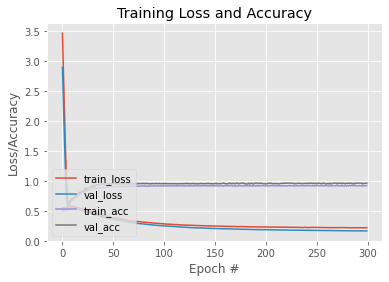

In [ ]:
plot_training(history,PLOT_PATH)

In [ ]:


acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

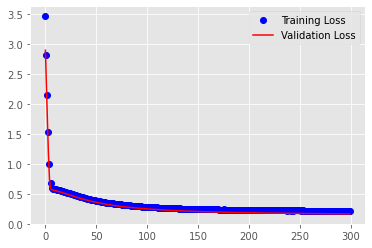

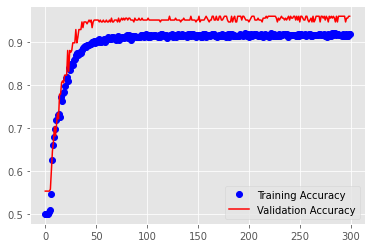

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epochs,loss,'bo',label="Training Loss")
plt.plot(epochs,val_loss,'r',label="Validation Loss")
plt.legend()
plt.show()

plt.plot(epochs,acc,'bo',label="Training Accuracy")
plt.plot(epochs,val_acc,'r',label="Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 128)          22808144    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[0][0]                

In [ ]:
BASE_OUTPUT='/content/drive/MyDrive/Datasets/'

#use the base output to derive the path to the serialized
#model along with training history plot

MODEL_PATH=os.path.sep.join([BASE_OUTPUT,"siamese_model"])

In [ ]:
model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Datasets//siamese_model/assets


In [ ]:
model2=Model(model.input,model.layers[0].output)
model2.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
Total params: 0
Trainable params: 0
Non-trainable params: 0
__________________________________________________________________________________________________
